# Building a neural autoencoder for embedding recipe data
The purpose of this walkthrough is to demonstrate how to build an autoencoder

An autoencoder is a neural network that takes an identical vector as input and output

The central layer of the network is smaller than the number of inputs

This design forces the network to learn a compressed representation of the data

This representation can then be used for applications like lookalike modeling, clustering, etc.

The data used in this example consists of recipe characteristics (vegan, gluten-free, appetizer dish, etc.)

Download the data here: https://www.kaggle.com/hugodarwood/epirecipes/version/2

### Import packages

In [322]:
import pandas as pd
import numpy as np

from IPython.display import display

from keras.layers import Dense
from keras.layers import Input
from keras.models import Model

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

#Adjust these for your display size if needed
plt.rcParams['figure.figsize'] = (40.0, 15.0)

# Import the data
#### Download the data using the link above and place the .csv into the directory *./data/*

In [344]:
dataset = pd.read_csv("data/epi_r.csv")
dataset.set_index("title",inplace=True)

#### Do some light data processing

In [345]:
#Eliminate duplicate recipes and NaNs
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)

#Some of the recipe characteristics are not informative, so manually remove them
columns_to_drop = ["bon appétit","gourmet"]
for column_name in columns_to_drop:
    dataset.drop(column_name,axis=1,inplace=True)

#Some recipes have unrealistic values for the macronutrients
dataset = dataset[dataset.calories < 2000]
dataset = dataset[dataset.protein < 2000]
dataset = dataset[dataset.fat < 2000]
dataset = dataset[dataset.sodium < 20000]

#### Check out a small sample of the recipe data

In [346]:
dataset.head()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Best Blts,4.375,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Determine the most commonly-populated fields for the recipe characteristcs

In [347]:
dataset.iloc[:,5:].sum(axis=0).sort_values(ascending=False)

peanut free                6005.0
soy free                   5803.0
tree nut free              4993.0
vegetarian                 4901.0
kosher                     4438.0
pescatarian                4353.0
quick & easy               3733.0
wheat/gluten-free          3458.0
bake                       3385.0
summer                     2975.0
dessert                    2600.0
winter                     2285.0
side                       2240.0
fall                       2223.0
dairy free                 2192.0
no sugar added             2151.0
dinner                     1718.0
sugar conscious            1683.0
kidney friendly            1644.0
onion                      1620.0
milk/cream                 1563.0
sauté                      1551.0
tomato                     1544.0
vegetable                  1532.0
fruit                      1452.0
egg                        1303.0
kid-friendly               1235.0
vegan                      1234.0
herb                       1231.0
spring        

#### There are a lot of columns, and some of them are sparsely-populated
#### Evaluate the distribution of values in the recipe charcteristics

In [348]:
#For each charcteristic, compute the number of recipes with the field populated
counts = dataset.iloc[:,5:].sum(axis=0)

#Calculate value counts of each total (i.e. how many characteristics have one non-zero entry, two non-zeros, etc.)
counts.value_counts().sort_index()[:25]

0.0     14
1.0     51
2.0     24
3.0     20
4.0     21
5.0     21
6.0     12
7.0     12
8.0     11
9.0     10
10.0     7
11.0     8
12.0    13
13.0     5
14.0     5
15.0     8
16.0     6
17.0     1
18.0     3
19.0     4
20.0     7
21.0     4
22.0     3
23.0     5
24.0     4
25.0     4
dtype: int64

#### There is a lot of sparsity in the data
#### Restrict these recipe characteristics to the top N most-populated columns

In [389]:
print("Total number of features: {}".format(len(dataset.iloc[:,5:].columns)))

Total number of features: 672


In [390]:
#Number of characteristics to retain
n_top_features = 100

#Determine which of the characteristics to keep
top_features = counts.sort_values(ascending=False).index[:n_top_features]

#Include the first five columns (rating, calories, protein, fat, sodium)
features_to_keep = list(dataset.columns[:5]) + list(top_features)
dataset_top_features = dataset[features_to_keep]

#Drop the recipes that do not have any of the N top features
dataset_top_features = dataset_top_features[dataset_top_features[top_features].sum(axis=1) > 0]

#### Rescale the data to [0,1]

In [391]:
#This scaling subtracts the minimum value from each column and then divides by the resulting maximum value
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(dataset_top_features)

dataset_scaled = scaler.transform(dataset_top_features)

# Build a neural network autoencoder
### Construct a neural network with a "bottleneck" in the interior
### Train the network on basket data with identical output
### The compressed data representation in the bottleneck is the "encoded" data

![Basic Network](images/Autoencoder.png)

### Create a neural network which will encode the data
##### The network architecture below is designed so that it can be separted into two models after training
- The encoder (the first and second layers)
- The decoder (the second and third layers)

In [392]:
#The input dimension equals the number of variables
input_dimension = dataset_scaled.shape[1]

#This parameter defines the size of the bottleneck
encoding_dimension = 32

#Optimizer choices: https://keras.io/optimizers/
optimizer = "adadelta"

#Loss function choices: https://keras.io/losses/
loss = "binary_crossentropy"

#Input layer
input_layer = Input(shape=(input_dimension,))

#The "encoded" layer holds the encoded representation
encoded = Dense(encoding_dimension, activation='relu')(input_layer)

#The "decoded" layer holds the reconstructed representation
decoded = Dense(input_dimension, activation='sigmoid')(encoded)

#Create the model mapping the input to its reconstruction
autoencoder = Model(input_layer, decoded)

#Create the model mapping the input to its encoded representation
encoder = Model(input_layer, encoded)

#Layer corresponding to encoded input
encoded_input = Input(shape=(encoding_dimension,))

#Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

#Create the model mapping the encoded information to its decoded representation
decoder = Model(encoded_input, decoder_layer(encoded_input))

#Compile the models
autoencoder.compile(optimizer=optimizer, loss=loss)

### Train the autoencoder using the data processed above
<a id='training'></a>

In [393]:
#The batch size determines how many records are in each "mini-batch"
batch_size = 64

#The number of epochs determines how many times the network is exposed to the dataset
epochs = 100

#This line trains the network
autoencoder.fit(dataset_scaled, dataset_scaled, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/100
 - 2s - loss: 0.3745
Epoch 2/100
 - 1s - loss: 0.2398
Epoch 3/100
 - 1s - loss: 0.2169
Epoch 4/100
 - 1s - loss: 0.2003
Epoch 5/100
 - 1s - loss: 0.1863
Epoch 6/100
 - 1s - loss: 0.1745
Epoch 7/100
 - 1s - loss: 0.1639
Epoch 8/100
 - 1s - loss: 0.1545
Epoch 9/100
 - 1s - loss: 0.1460
Epoch 10/100
 - 1s - loss: 0.1383
Epoch 11/100
 - 1s - loss: 0.1312
Epoch 12/100
 - 1s - loss: 0.1247
Epoch 13/100
 - 1s - loss: 0.1186
Epoch 14/100
 - 1s - loss: 0.1131
Epoch 15/100
 - 1s - loss: 0.1080
Epoch 16/100
 - 1s - loss: 0.1033
Epoch 17/100
 - 1s - loss: 0.0989
Epoch 18/100
 - 1s - loss: 0.0949
Epoch 19/100
 - 1s - loss: 0.0913
Epoch 20/100
 - 1s - loss: 0.0879
Epoch 21/100
 - 1s - loss: 0.0847
Epoch 22/100
 - 1s - loss: 0.0819
Epoch 23/100
 - 1s - loss: 0.0792
Epoch 24/100
 - 1s - loss: 0.0768
Epoch 25/100
 - 1s - loss: 0.0745
Epoch 26/100
 - 1s - loss: 0.0724
Epoch 27/100
 - 1s - loss: 0.0704
Epoch 28/100
 - 1s - loss: 0.0686
Epoch 29/100
 - 1s - loss: 0.0669
Epoch 30/100
 - 1s - lo

### Generate the encoded and decoded versions of the training data

In [394]:
#Encoding then decoding should equate to an identity operation (with some data loss from the compression)
dataset_encoded = encoder.predict(dataset_scaled)
dataset_decoded = decoder.predict(dataset_encoded)

### Verify that the autoencoder compresses and decompresses the data

In [395]:
#Choose an arbitrary index to display
idx = 2

print("Original rescaled record")
display(dataset_scaled[idx])

print("Encoded record")
display(dataset_encoded[idx])

print("Decoded record")
display(dataset_decoded[idx])

print("Decoded record after rounding")
display(np.round(dataset_decoded[idx],decimals=2))

Original rescaled record


array([0.75      , 0.08278976, 0.01834862, 0.03608247, 0.00861664,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Encoded record


array([3.0477293 , 3.2898602 , 2.1429574 , 5.542844  , 1.9327751 ,
       1.9317272 , 2.719634  , 2.3931172 , 2.2723904 , 0.98448986,
       2.5262089 , 2.256259  , 2.9662552 , 2.3423893 , 3.2562137 ,
       2.06715   , 4.1467485 , 4.4936075 , 2.80291   , 3.8557582 ,
       4.13142   , 1.2941141 , 5.2419443 , 2.4663682 , 2.1980927 ,
       4.1053658 , 5.509043  , 6.577567  , 2.2475722 , 0.8202397 ,
       1.6223574 , 1.5410426 ], dtype=float32)

Decoded record


array([7.00467527e-01, 2.06309795e-01, 5.41219786e-02, 9.57557932e-02,
       2.50817705e-02, 1.01252781e-05, 1.08743858e-04, 7.00923993e-05,
       8.12073704e-04, 1.02754566e-04, 6.89574733e-07, 2.00619688e-04,
       5.06143842e-04, 1.45145087e-03, 1.73140189e-03, 6.87537806e-07,
       1.95099926e-03, 8.85206900e-05, 2.72970326e-04, 5.49578338e-08,
       8.19712994e-04, 9.60656871e-06, 3.33405296e-05, 9.09348330e-07,
       5.35565370e-04, 1.93632883e-03, 7.07457599e-04, 6.00702242e-06,
       9.98357475e-01, 4.88955848e-05, 2.87762407e-04, 5.50101104e-05,
       1.00691859e-05, 2.97278468e-03, 1.93615051e-05, 2.18465240e-04,
       1.16423485e-04, 9.94208574e-01, 7.67434827e-08, 1.22853613e-03,
       1.90884538e-03, 2.07610242e-03, 2.25224369e-03, 1.33530237e-04,
       5.23944804e-03, 9.97311711e-01, 3.80947131e-05, 9.96672750e-01,
       9.54120915e-05, 1.39487034e-04, 1.94179593e-05, 1.68132351e-03,
       5.54333034e-04, 1.75053181e-04, 2.53581069e-03, 4.98317604e-07,
      

Decoded record after rounding


array([0.7 , 0.21, 0.05, 0.1 , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 1.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.02, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

### Functions to assess the performance of the model

In [396]:
def cosine_similarity(vector1,vector2):
    denominator = np.sqrt(sum([k**2 for k in vector1])) * np.sqrt(sum([k**2 for k in vector2]))
    return sum([vector1[idx] * vector2[idx] for idx in range(len(vector1))])/denominator

def compute_similarities(vector,array):
    return np.array([cosine_similarity(vector,row) for row in array])

def compute_closest(vector,array,matches=5):
    distances = compute_similarities(vector,array)
    closest_records = np.argsort(-distances)[:matches]
    closest_distances = -np.sort(-distances)[:matches]
    return closest_records,closest_distances

def compute_magnitudes(vector):
    return np.sqrt((vector*vector).sum(axis=1))

def compute_average_magnitude_ratio(numerator,denominator):
    ratios = compute_magnitudes(numerator)/compute_magnitudes(denominator)
    return ratios.mean()

### Quantify the distances between records and their reconstructions

Mean cosine distance: 0.027862274961266795
Mean magnitude ratio: 1.0637144237842229


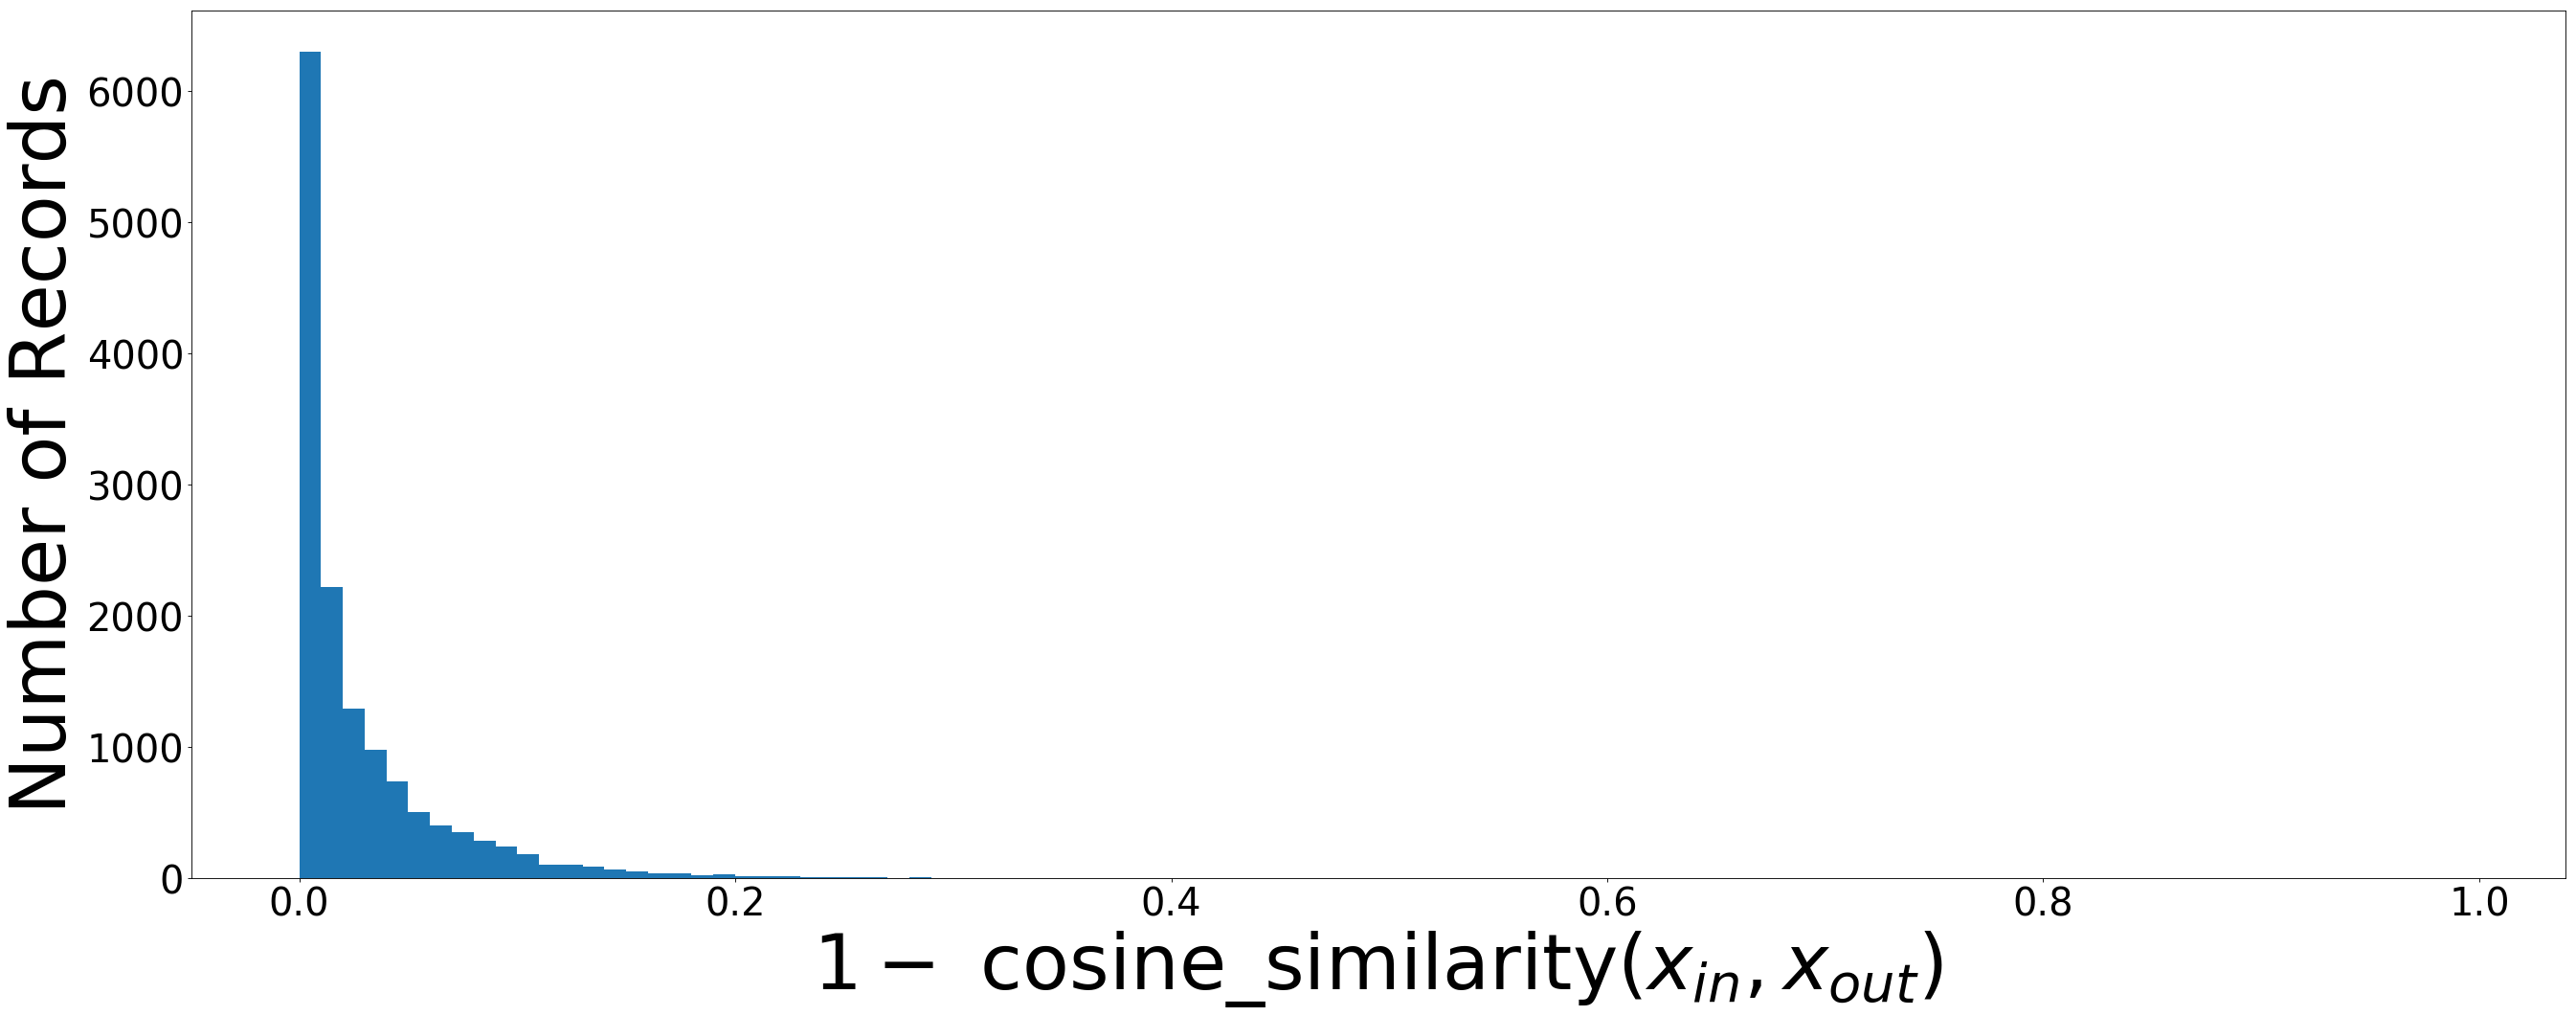

In [397]:
distances = [1 - cosine_similarity(dataset_scaled[n],dataset_decoded[n]) for n in range(len(dataset_scaled))]
print("Mean cosine distance: {}".format(np.mean(distances)))

magnitude_ratio = compute_average_magnitude_ratio(dataset_scaled,dataset_decoded)
print("Mean magnitude ratio: {}".format(magnitude_ratio))

plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.hist(distances,bins=np.arange(0,1,0.01))

plt.xlabel('$1 -$ cosine_similarity$(x_{in},x_{out})$')
plt.ylabel('Number of Records')
plt.rc('axes', labelsize=72)
plt.rc('xtick', labelsize=36)
plt.rc('ytick', labelsize=36)

### Continue training the model by clicking [here](#training)
##### Some ideas on refining your network's performance:
- If the training error has plateaued, reduce the batch size and keep training
- Networks with more nodes have more parameters and are better at generalizing
- Changing the optimizer or loss function will result in a different set of weights
- There is a natural limit to how far data can be compressed and you may have reached that point

# Application: Lookalike Modeling
#### One of the advantages of autoencoders is that it is straightforward to define "similarity" using the encoded data
#### Use the cosine similarity metric to determine which recipes are most similar to a given input
#### The encoded representation is a nonlinear combination of the input features
#### The result is presented in the original variables

In [407]:
#Number of lookalikes to return
matches = 5

#Choose an arbitrary records
input_ID = np.random.choice(range(len(dataset_top_features)))
input_record = dataset_encoded[input_ID]

#Find the most similar records using the cosine distance as a metric
closest_indices,closest_distances = compute_closest(input_record,dataset_encoded,matches=matches)
data_closest = dataset_top_features.iloc[closest_indices]
data_closest.insert(loc=0,column="similarity",value=closest_distances)

#Display only the columns with non-zero content
sums = data_closest.sum(axis=0)
nonzero_sums = np.nonzero(sums > 0)[0]
informative_columns = data_closest.columns[nonzero_sums]

print("Closest recipes:")
display(data_closest[informative_columns])

Closest recipes:


,similarity,rating,calories,protein,fat,sodium,quick & easy,bake,fall,tomato,cheese,pasta,olive,shellfish,white wine,shrimp
title,,,,,,,,,,,,,,,,
"Baked Orzo with Shrimp, Tomato Sauce, and Feta",1.000000,3.750,636.0,37.0,24.0,1701.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Rigatoni with Shrimp in Tomato and Feta Sauce,0.983402,3.750,634.0,33.0,24.0,1296.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Double Olive Pasta,0.961178,3.750,451.0,16.0,20.0,863.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Large Shell Pasta with Seafood Sauce,0.956455,3.750,609.0,42.0,14.0,583.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
Shrimp and Crab Cannelloni,0.952900,4.375,679.0,31.0,38.0,722.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Search recipes by formulating a query
#### Another application using similarity is to create an input recipe "query" and determine the closest recipes
#### This methodology is similar to approaches taken by Yummly and other recipe search engines

In [402]:
#Display a sorted list of the options for recipe features
#sorted(list(top_features))

In [408]:
#Build an artificial record to input into the lookalike model
query = pd.Series([0]*dataset_top_features.shape[1],index=dataset_top_features.columns)

query["rating"] = 5

query["dinner"] = 1
query["bake"] = 1
query["vegetarian"] = 1

query_scaled = scaler.transform(np.array([query.values]))
query_encoded = encoder.predict(query_scaled)[0]

#### Use this "query" recipe to find the most similar recipes in the dataset

In [409]:
matches = 10

#Find the most similar records using the cosine distance as a metric
closest_indices,closest_distances = compute_closest(query_encoded,dataset_encoded,matches=matches)
data_closest = dataset_top_features.iloc[closest_indices]
data_closest.insert(loc=0,column="similarity",value=closest_distances)

#Display only the columns with non-zero content
sums = data_closest.sum(axis=0)
nonzero_sums = np.nonzero(sums > 0)[0]
informative_columns = data_closest.columns[nonzero_sums]

print("Closest recipes:")
display(data_closest[informative_columns])

Closest recipes:


,similarity,rating,calories,protein,fat,sodium,vegetarian,wheat/gluten-free,bake,dinner,vegan,potato,nut
title,,,,,,,,,,,,,
Parsnip Gnocchi,0.983792,3.125,430.0,9.0,19.0,364.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Leek and Potato Galette With Pistachio Crust,0.983185,5.000,1117.0,23.0,72.0,663.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
Caraway Cabbage Chips with Dill Yogurt,0.980837,2.500,107.0,3.0,9.0,35.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Candied Cashews,0.979056,5.000,230.0,6.0,18.0,124.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
Pizza Dough,0.976392,4.375,470.0,10.0,14.0,875.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
Toasted Salted Pumpkin Seeds,0.975283,5.000,260.0,13.0,23.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Junior's Russian Dressing,0.974275,5.000,337.0,2.0,26.0,1303.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Spicy Tofu Crumbles,0.972956,4.375,178.0,13.0,13.0,577.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Spiced Poached Pears with Crème Fraîche and Amaretto Cookies,0.972859,4.375,312.0,1.0,5.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Not perfect, but it could be developed into a useful recipe search engine